# Lab 2: Regularized Least Square
In this lab, we focus on RLS to address linear regression problems. 

In this lab, we have to:
- **(Task 1)** implement RLS to solve linear regression problems
- **(Task 2)** observe performance of RLS changing the noise in the data and the regularization parameter
- **(Task 3)** implement K-Fold Cross-Validation algorithm for RLS


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

## Data generation
To generate linear regression data, we use the `linearRegrFunction` introduced in Lab0.

In [15]:
def linearRegrFunction(n, D, low_D, high_D, W, sigma_noise):
    X = np.zeros((n,D))
    for i in range(0, D):
        X[:,i] = np.random.uniform(low_D[i], high_D[i], size=n)
    
    gauss_noise = np.random.normal(0, sigma_noise, size=(n,1))

    Y = np.dot(X, W) + gauss_noise
    
    return X, Y 

### Example: Noiseless dataset


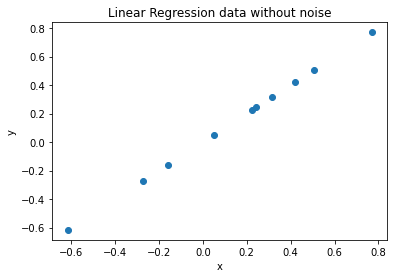

In [16]:
n = 10
D = 1
low_D, high_D = [-1], [1]
w = np.array(1.0).reshape(1, 1)
noise_std = 0.0

# Data generation
X, Y = linearRegrFunction(n, D, low_D, high_D, w, noise_std)

# Plot of the data
_, ax = plt.subplots()
ax.set_title("Linear Regression data without noise")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.scatter(X, Y)

## Task 1: RLS regressor
We want to implement the `regularizedLSTrain` function which train RLS regression.

The signature of `regularizedLSTrain` is the following:

`w = regularizedLSTrain(Xtr, Ytr, lam)`

where:
- **Xtr** are the training inputs
- **Ytr** are the training outputs
- **lam** is the regularization parameter $\lambda$

To implement this function, you will need to use the following functions from numpy:

- [`np.linalg.cholesky`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html)
- [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html)

Consider 

**$(X_{tr}^\intercal X_{tr} + \lambda n I)w = X_{tr}^\intercal Y_{tr}$**

Let $A = X_{tr}^\intercal X_{tr} + \lambda n I$ and $b = X_{tr}^\intercal Y_{tr}$, we can find $w$ with the following steps:
1. First build the left-hand side matrix `A`, and the right-hand side matrix `b`.
2. Compute the Cholesky decomposition of `A` (note that the numpy function will provide a lower-triangular matrix)
3. You will have to solve two triangular systems, one using the Cholesky decomposition, and the other using its transpose.

In [17]:
def regularizedLSTrain(Xtr, Ytr, lam):
    Xtr_T = np.transpose(Xtr)
    A = Xtr_T @ Xtr + lam * Xtr.shape[0] * np.identity(Xtr.shape[1])
    b = Xtr_T @ Ytr

    decomp = np.linalg.cholesky(A)
    w1 = scipy.linalg.solve_triangular(decomp, np.identity(decomp.shape[1]), lower=True)
    w2 = scipy.linalg.solve_triangular(np.transpose(decomp), np.identity(decomp.shape[0]))
    return w1 @ w2 @ b

We need also to implement a function `regularizedLSTest` which given a test set `Xte` and the `w` obtained using `regularizedLSTrain`, it returns `Ypred` containing the predictions

In [18]:
def regularizedLSTest(w, Xte):
    return Xte @ w

To evaluate the performance of RLS regressor, we need a function to estimate the error.

Given two vectors `Ytrue` (real outputs) and `Ypred` (predicted outputs), we can measure the error obtained when predicting `Ypred` instead of `Ytrue` with the MSE (Mean Square Error)

In [19]:
def calcError(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

Now we can build an easy example to observe how our model works:
- Generate a training set with **ntrain** points and a test set with **ntest** points 
- Train RLS with `regularizedLSTrain` function and test it with `regularizedLSTest` on test set
- Compute the training and test error 

In [20]:
ntrain = 100
ntest = 50
D = 1
low_D = [-1] * D
high_D = [5] * D
rnd_state = np.random.RandomState(42)
wtrue = rnd_state.randn(D, 1) 
noise_std = 0.1

lam = 1e-3

# Generate a training set with ntrain points and a test set with ntest 
Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, wtrue, noise_std)
Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, wtrue, noise_std)

# Train RLS
w = regularizedLSTrain(Xtr, Ytr, lam)

# Compute predictions on training and test set
Ytr_pred = regularizedLSTest(w, Xtr)
Yte_pred = regularizedLSTest(w, Xte)

train_err = calcError(Ytr_pred, Ytr)
test_err = calcError(Yte_pred, Yte)

print("[--] Training error: {}\tTest error: {}".format(train_err, test_err))

[--] Training error: 0.009497708927186165	Test error: 0.010146626169475426


## Task 2: Changing $\lambda$
Now we can play with our model changing the noise level in the data and changing the $\lambda$ parameter.

Let's start by changing $\lambda$ and fixing the other parameters.

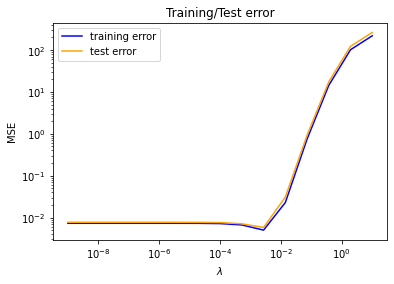

In [21]:
ntrain = 500
ntest = 100
D = 2
low_D = [-2] * D
high_D = [2] * D
w_true = np.array([i for i in range(D)]).reshape(D, 1) + 10
noise_std = 0.01


# Data generation
Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, w_true, noise_std)
Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, w_true, noise_std)

lam_list = np.logspace(-9, 1, 15)
tr_err = []
te_err = []

for lam in lam_list:

    # Train RLS
    w = regularizedLSTrain(Xtr, Ytr, lam)
    
    # Compute predictions on training and test set
    Ytr_pred = regularizedLSTest(w, Xtr)
    Yte_pred = regularizedLSTest(w, Xte)
    
    # Compute training and test error and store them on tr_err and te_err
    tr_err.append(calcError(Ytr_pred, Ytr))
    te_err.append(calcError(Yte_pred, Yte))


# Plot training and test error
_, ax = plt.subplots()
ax.set_title("Training/Test error")
ax.plot(lam_list, tr_err, '-', c="blue", label="training error")
ax.plot(lam_list, te_err, '-', c="orange", label="test error")
ax.legend(loc="best")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.set_xscale("log")
ax.set_yscale("log")


Now, increase the amount of noise and repeat the experiment. What do you observe?

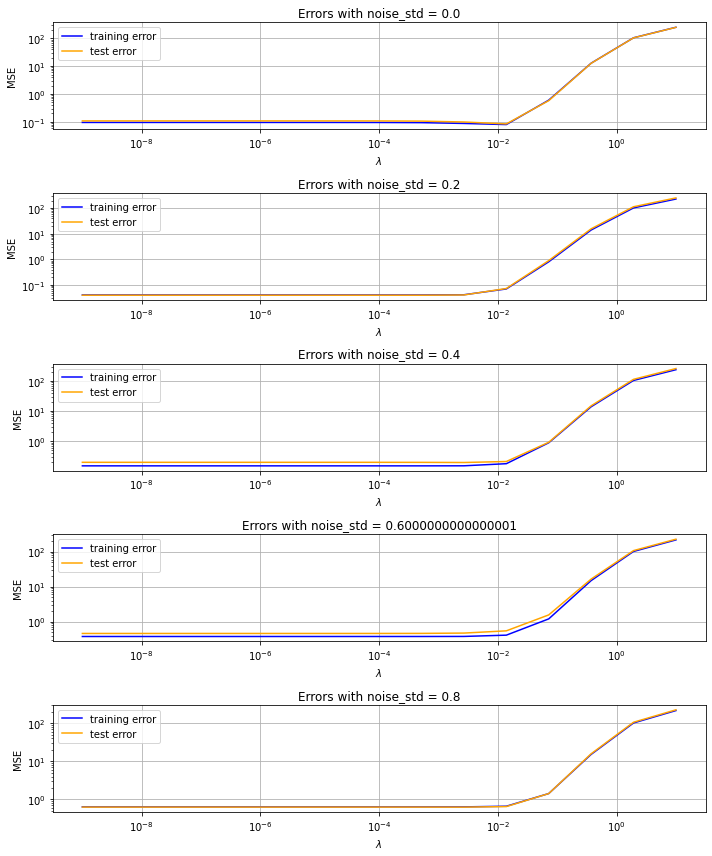

In [22]:
ntrain = 500
ntest = 100
D = 2
low_D = [-2] * D
high_D = [2] * D
w_true = np.array([i for i in range(D)]).reshape(D, 1) + 10
noise_stds = np.arange(0, 1, 0.2)

tr_errs = []
te_errs = []

for noise_std in noise_stds:
    # Data generation
    Xtr, Ytr = linearRegrFunction(ntrain, D, low_D, high_D, w_true, noise_std)
    Xte, Yte = linearRegrFunction(ntest, D, low_D, high_D, w_true, noise_std)

    lam_list = np.logspace(-9, 1, 15)
    tr_err = []
    te_err = []

    for lam in lam_list:

        # Train RLS
        w = regularizedLSTrain(Xtr, Ytr, lam)
        
        # Compute predictions on training and test set
        Ytr_pred = regularizedLSTest(w, Xtr)
        Yte_pred = regularizedLSTest(w, Xte)
        
        # Compute training and test error and store them on tr_err and te_err
        tr_err.append(calcError(Ytr_pred, Ytr))
        te_err.append(calcError(Yte_pred, Yte))

    tr_errs.append(tr_err)
    te_errs.append(te_err)

# Plot training and test error
fig = plt.figure(figsize=(10, 12))
for i in range(len(noise_stds)):
    plt.subplot(len(noise_stds),1,i+1)
    plt.title(f"Errors with noise_std = {noise_stds[i]}")
    plt.plot(lam_list, tr_errs[i], '-', c="blue", label="training error")
    plt.plot(lam_list, te_errs[i], '-', c="orange", label="test error")
    plt.legend(loc="best")
    plt.xlabel("$\lambda$")
    plt.ylabel("MSE")
    plt.xscale("log")
    plt.yscale("log")
    plt.grid()
fig.tight_layout()

### Comment

We can notice overall that the error increases with the noise level. The plot are all similar to one another but by observing the y axis we can see that with the same $\lambda$, as the noise increases, the MSE increases too.

## Task 3: K-Fold Cross Validation for RLS
Now, we want to implement the K-Fold Cross Validation for RLS. 

In specific we want to implement the `KFoldCVRLS` function which, given a training set **Xtr** and **Ytr**, a number of folds **KF** and a set of values for $\lambda$ (**regpar_list**) and returns the $\lambda$ which minimize the average validation error **bestlam**, the mean validation error **val_mean**, the validation error variance **val_var**, the mean training error **tr_mean** and the training error variance **tr_var**.

`bestlam, val_mean, val_var, tr_mean, tr_var = KFoldCVRLS(Xtr, Ytr, KF, regpar_list)`

**Hint:** this function is very similar to K-Fold Cross-Validation algorithm for KNN (Lab1)

In [23]:
def KFoldCVRLS(Xtr, Ytr, KF, regpar_list):
    if KF <= 1:
        raise Exception("Please supply a number of fold > 1")

    # Ensures that regpar_list is a numpy array
    regpar_list = np.array(regpar_list)
    num_regpar = regpar_list.size

    n_tot = Xtr.shape[0]
    n_val = int(n_tot // KF)

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_regpar, KF))
    val_errors = np.zeros((num_regpar, KF))

    for idx, regpar in enumerate(regpar_list):
        # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
        rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
        split_idx = np.array_split(rand_idx, KF)
        for fold in range(KF):
            # Set the indices in boolean mask for all validation samples to `True`
            val_mask = np.zeros(n_tot, dtype=bool)
            val_mask[split_idx[fold]] = True

            # Use the boolean mask to split X, Y in training and validation part

            X = Xtr[~val_mask] # training input 
            Y = Ytr[~val_mask] # training output 
            X_val = Xtr[val_mask] # validation input
            Y_val = Ytr[val_mask] # validation output
            
            # Train a RLS model for a single fold, and the given value of `regpar`
            currW = regularizedLSTrain(X, Y, regpar)
            
            # Compute the training error of the RLS regression for the given value of regpar
            YpredTR = regularizedLSTest(currW, X)
            tr_errors[idx, fold] = calcError(YpredTR, Y)

            # Compute the validation error of the RLS regression for the given value of regpar
            YpredVAL = regularizedLSTest(currW, X_val)
            val_errors[idx, fold] = calcError(YpredVAL, Y_val)
            
    # Calculate error statistics along the repetitions
    tr_mean = np.mean(tr_errors, axis=1)
    tr_var = np.var(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_var = np.var(val_errors, axis=1)
    
    bestlam_idx = np.argmin(val_mean)
    bestlam = regpar_list[bestlam_idx]

    return bestlam, val_mean, val_var, tr_mean, tr_var

Use `KFoldCVRLS` to find the best regularization parameter 

<Figure size 720x864 with 0 Axes>

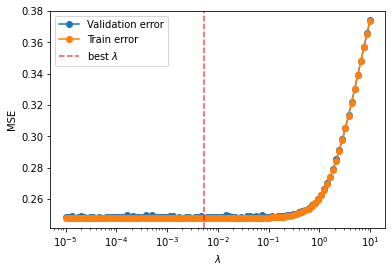

In [24]:
n = 1000
D = 1
sigma_noise = 0.5
truew = np.random.randn(D, 1)
reg_pars = np.logspace(-5, 1, 100)
KF = 5

low_D = [-3] * D
high_D = [3] * D

# Generate training set
Xtr, Ytr =  linearRegrFunction(n, D, low_D, high_D, truew, sigma_noise)

# Compute best lambda
bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars)


# Plot training and validation error
_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation error")
ax.plot(reg_pars, Tm, '-o', label="Train error")
ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best")

Use the best $\lambda$ found to train the model on the full training set and compute the test error on the following test set.   

In [75]:
Xte, Yte = linearRegrFunction(200, D, low_D, high_D, truew, sigma_noise)

print("[--] best lambda found: {}".format(bestlam))

# Insert your code here
w_best = regularizedLSTrain(Xtr, Ytr, bestlam)
Ypred_best = regularizedLSTest(w_best, Xte)
test_err = calcError(Ypred_best, Yte)

print("[--] Test error: {}".format(test_err))

[--] best lambda found: 0.003511191734215131
[--] Test error: 0.258861635634209


What changes if you repeat the latter step with a value of Lambda which is not the optimal?

In [76]:
for lam in reg_pars[::5]:
    if lam != bestlam:
        w_best = regularizedLSTrain(Xtr, Ytr, lam)
        Ypred_best = regularizedLSTest(w_best, Xte)
        test_err = calcError(Ypred_best, Yte)
        print("[--] Test error: {}".format(test_err))

[--] Test error: 0.25900999818928183
[--] Test error: 0.25900955747461607
[--] Test error: 0.2590086722048358
[--] Test error: 0.2590068944146831
[--] Test error: 0.2590033261462887
[--] Test error: 0.2589961717038326
[--] Test error: 0.25898185745679714
[--] Test error: 0.2589533416427332
[--] Test error: 0.2588970336851166
[--] Test error: 0.2587878702635012
[--] Test error: 0.2585844754229511
[--] Test error: 0.2582393809862338
[--] Test error: 0.2577964766045336
[--] Test error: 0.2578695781638036
[--] Test error: 0.26154285074779304
[--] Test error: 0.28064495731275874
[--] Test error: 0.3511372889437915
[--] Test error: 0.5508646595105113
[--] Test error: 0.9683081368501414
[--] Test error: 1.5834259628100222


### Comment

Overall, with a value of $\lambda$ which is not optimal, we have higher test errors. Notice though that there might be also some cases where the test error is lower than the one obtained with the optimal $\lambda$, this is because with the optimal $\lambda$ we don't overfit the data.

### To go deeper

Create new training **and** test datasets, sampled in a non-symmetric range (for example you can set the `low_D` and `high_D` parameters of the `linearRegrFunction` function to 2 and 5).

Then repeat the K-fold CV procedure, and check whether the best regularization parameter changes!

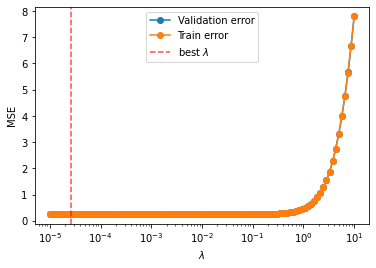

In [95]:
n = 1000
D = 1
sigma_noise = 0.5
truew = np.random.randn(D, 1)
reg_pars = np.logspace(-5, 1, 100)
KF = 5

low_D = [2] * D
high_D = [5] * D

Xtr, Ytr =  linearRegrFunction(n, D, low_D, high_D, truew, sigma_noise)

bestlam, Vm, Vs, Tm, Ts = KFoldCVRLS(Xtr, Ytr, KF, reg_pars)

_, ax = plt.subplots()
ax.plot(reg_pars, Vm, '-o', label="Validation error")
ax.plot(reg_pars, Tm, '-o', label="Train error")
ax.axvline(bestlam, linestyle="--", c="red", alpha=0.7, label="best $\lambda$")
ax.set_xscale("log")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("MSE")
ax.legend(loc="best")

### Comment

The best regularization parameter doesn't change much, as well as the error. Overall this is because even by changing the "range" of the data and by considering a non-symmetric one, they still pass through the origin.